In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random
from tqdm import trange

In [2]:
DEV = "cuda:0" if torch.cuda.is_available() else "cpu"
DEV = torch.device(DEV)
DEV

device(type='cuda', index=0)

## Load data

In [3]:
!wget https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
with open("ortak_kelimeler.txt", encoding='utf-8') as f:
    text = f.read()

In [5]:
words = text.split("\n")

In [6]:
long_text = text.replace("\n","")
ids = list(set(long_text))
len(ids)

29

In [7]:
ordinal_char_pairs = sorted([(ord(c),c) for c in ids])
ordinal_char_pairs

[(97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (121, 'y'),
 (122, 'z'),
 (231, 'ç'),
 (246, 'ö'),
 (252, 'ü'),
 (287, 'ğ'),
 (305, 'ı'),
 (351, 'ş')]

In [8]:
len(ordinal_char_pairs)

29

## Encode & Decode Functions

In [9]:
ctoi = {c:i for i,(o,c) in enumerate(ordinal_char_pairs)}
itoc =  {i:c for i,(o,c) in enumerate(ordinal_char_pairs)}

In [10]:
ctoi['.']=len(ctoi)
itoc[len(itoc)]='.'

In [11]:
def encode(input:str):
    return [ctoi[c] for c in input]

def decode(ids):
    return "".join([itoc[i] for i in ids])

In [12]:
assert decode(encode("zemberek"))=='zemberek'

## Helpers

In [13]:
def plot_training_loss(nn, aggregate = 50):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    losses = nn.losses
    n = (len(losses) // aggregate)*aggregate
    losses = torch.tensor(losses[:n]).view(-1,aggregate).mean(1)

    val_losses = nn.val_losses
    n = (len(val_losses) // aggregate)*aggregate
    val_losses = torch.tensor(val_losses[:n]).view(-1,aggregate).mean(1)

    axs[0].plot(losses, label="Neural net train loss")
    axs[0].plot(val_losses, label="Neural net val loss")
    axs[0].set_title('Losses')
    axs[0].legend()

    axs[1].plot([g[1] for g in nn.grads], label="Max")
    axs[1].plot([g[0] for g in nn.grads], label="Min")
    axs[1].plot([g[2] for g in nn.grads], label="Mean")
    axs[1].plot([g[3] for g in nn.grads], label="Std.")
    axs[1].set_title('Gradients')
    axs[1].legend()

    plt.show()

## Prepare Training Data

In [14]:
random.seed(13)
random.shuffle(words)

long_text = "."+".".join([w for w in words])+"."

n = len(long_text)
n1 = int(n*0.8)
n2 = int(n*0.9)

In [15]:
data = torch.tensor(encode(long_text), dtype=torch.long)

## Train

In [16]:
class Trainer:
    def __init__(self, batch_size, block_size) -> None:
        
        self.batch_size = batch_size
        self.block_size = block_size

        # for logging
        self.losses = []
        self.val_losses = []
        self.grads = []    

    def train(self, nn:nn.Module, train_data, eval_data=None, lr=0.1, threshold=None, steps=1001, print_steps=10):
        if steps>1:
            print(f"Model has {sum([p.nelement() for p in nn.parameters()])} parameters!")
            print(f"Using {len(train_data)} samples")

        # set default loss value to zero
        loss = val_loss = torch.zeros((1))[0]

        # training loop
        for i in range(steps):
            bxs, bys = self.get_batch(train_data)

            # FORWARD
            logits = nn(bxs)

            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            bys = bys.view(B*T)
            # loss: negative log likelihood
            loss = F.cross_entropy(logits, bys)
            
            # backward
            nn.zero_grad()
            loss.backward()

            if threshold and i > threshold:
                lr = lr * 0.5
                 
            # update weights
            for p in nn.parameters():
                p.data -= lr * p.grad

            # log validation loss
            if eval_data is not None:
                val_loss = self.evaluate(nn, eval_data)

            # report losses
            if steps>1 and i % print_steps == 0:
                print(f"Step {i} | loss: {loss.item():.4f} | val loss: {val_loss.item():.4f}")

            _params = list(nn.parameters())
            # logging
            self.losses.append(loss.item())
            self.grads.append([
                min([p.grad.min().item() for p in _params]),
                max([p.grad.max().item() for p in _params]),
                sum([p.grad.mean().item() for p in _params])/len(_params),
                sum([p.grad.std().item() for p in _params])/len(_params)
            ]
            )

        if steps>1:
            print(f"loss: {loss.item():.4f} validation loss: {val_loss.item():.4f}")

        pass

    @torch.no_grad()
    def evaluate(self, nn, data):
        nn.train(False) # eval mode
        
        val_bxs, val_bys = self.get_batch(data)
        val_logits = nn(val_bxs)
        
        B,T,C = val_logits.shape
        val_logits = val_logits.view(B*T,C)
        val_bys = val_bys.view(B*T)
        
        val_loss = F.cross_entropy(val_logits, val_bys)
                    
        self.val_losses.append(val_loss.item())
        
        nn.train(True) # back to train mode

        return val_loss

    def get_batch(self, data):
        ix = torch.randint(len(data)-self.block_size, (self.batch_size  if self.batch_size else len(data),))

        x = torch.stack([data[i:i+self.block_size] for i in ix])
        y = torch.stack([data[i+1:i+self.block_size+1] for i in ix])

        x, y = x.to(DEV), y.to(DEV)
        return x, y

In [17]:
def generate(nn, block_size):
    reverse_offset = -block_size
    n_start_chars = block_size

    chars = torch.tensor([ctoi['.']]*n_start_chars, device=DEV).view(1,-1)

    while True:
        input = chars[:,reverse_offset:]
        logits = nn(input)
        probs = F.softmax(logits, dim=-1)
        assert probs.shape == (1, block_size, 30), f"{probs.shape=}"

        probs_in = probs[0, -1, :]
        next_char = torch.multinomial(probs_in, 1, replacement=True)

        if next_char.item() == ctoi['.']:
            return decode(list(chars.cpu()[0].numpy())[n_start_chars:])
        
        chars = torch.concat((chars, next_char.view(1, -1)), dim=-1)

In [18]:
def lr_search(nn, data, block_size, steps=1001):
        lre = torch.linspace(-3, 0, steps)
        lrs = 10**lre

        lri = []
        trainer = Trainer(block_size=block_size, batch_size=1)
        for i in trange(steps):
            lr = lrs[i]
            
            trainer.train(nn, data, lr = lr, steps=1)
            
            lri.append(lre[i])

        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        ax.plot(lri[::20], torch.tensor(trainer.losses).view(-1,20).mean(1), label="average loss")
        ax.plot(lri, trainer.losses, label="loss")
        ax.legend()

        plt.show()

In [24]:
class AttentionHead(nn.Module):
    def __init__(self, n_embd, block_size):
        super().__init__()
        # k,q,v
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):

        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)

        # normalized q*v calculcation
        wei = q @ k.transpose(-2, -1) * C ** -0.5 

        # future token mask (attention for decoder only models)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        
        # softmax 
        wei = F.softmax(wei, dim=-1)
        
        # value 
        v = self.value(x)
        out = wei @ v 

        # linear projection
        prj = self.proj(out)

        return prj
    
class AttentionLm(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size):
        super().__init__()

        self.vocab_size = vocab_size
        self.block_size = block_size
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.sa = AttentionHead(n_embd, block_size)
        self.ffwd = nn.Sequential(
                nn.Linear(n_embd, 4 * n_embd),
                nn.ReLU(),
                nn.Linear(4 * n_embd, n_embd)
            )
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx):
        B, T = idx.shape

        assert T == self.block_size

        # prepare embeddings
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEV))
        x = tok_emb + pos_emb  # (B,T,C)
        
        # attention block calculation
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))

        # lm head projection
        x = self.ln_f(x)
        logits = self.lm_head(x)

        assert logits.shape == (B, T, self.vocab_size)

        return logits

100%|██████████| 1020/1020 [00:17<00:00, 57.54it/s]


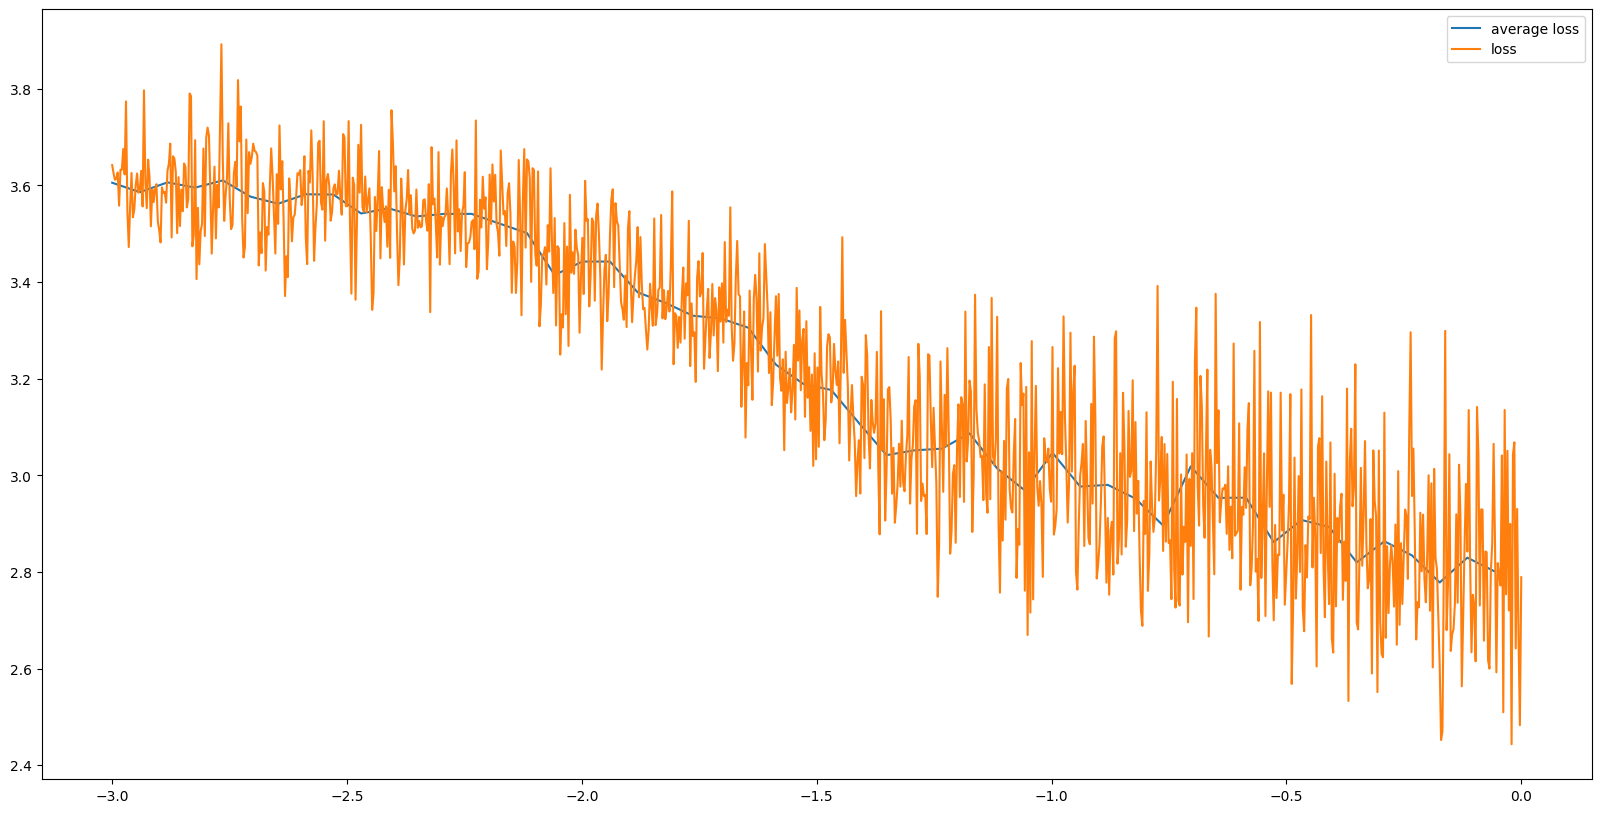

CPU times: total: 18 s
Wall time: 18.2 s


In [20]:
%%time

torch.manual_seed(13)

block_size = 32
n_embd = 9

nn4 = AttentionLm(vocab_size=30, n_embd=n_embd, block_size=block_size, n_head=3, n_layer=1)
nn4.to(DEV)

lr_search(nn4, data[:3000], block_size=block_size, steps=1020)

Right learning rate is not obvious from the chart above.

In [45]:
%%time

torch.manual_seed(13)

block_size = 32
batch_size = 1024
n_embd = 16
attention_lm = AttentionLm(30, n_embd, block_size)
attention_lm.to(DEV)

trainer = Trainer(batch_size=batch_size, block_size=block_size)
trainer.train(attention_lm, data[:n1], data[n1:n2], lr=0.3, steps=1000)

Model has 4766 parameters!
Using 293663 samples
Step 0 | loss: 3.6013 | val loss: 3.5534
Step 10 | loss: 3.2544 | val loss: 3.2237
Step 20 | loss: 3.0831 | val loss: 3.0750
Step 30 | loss: 3.0157 | val loss: 3.0133
Step 40 | loss: 2.9927 | val loss: 2.9891
Step 50 | loss: 2.9588 | val loss: 2.9664
Step 60 | loss: 2.9600 | val loss: 2.9383
Step 70 | loss: 2.9371 | val loss: 2.9347
Step 80 | loss: 2.9256 | val loss: 2.9262
Step 90 | loss: 2.9081 | val loss: 2.9132
Step 100 | loss: 2.8925 | val loss: 2.8968
Step 110 | loss: 2.8950 | val loss: 2.8961
Step 120 | loss: 2.8813 | val loss: 2.8809
Step 130 | loss: 2.8754 | val loss: 2.8675
Step 140 | loss: 2.8660 | val loss: 2.8661
Step 150 | loss: 2.8511 | val loss: 2.8526
Step 160 | loss: 2.8432 | val loss: 2.8471
Step 170 | loss: 2.8380 | val loss: 2.8447
Step 180 | loss: 2.8261 | val loss: 2.8218
Step 190 | loss: 2.8178 | val loss: 2.8126
Step 200 | loss: 2.8040 | val loss: 2.8062
Step 210 | loss: 2.7969 | val loss: 2.7913
Step 220 | loss: 

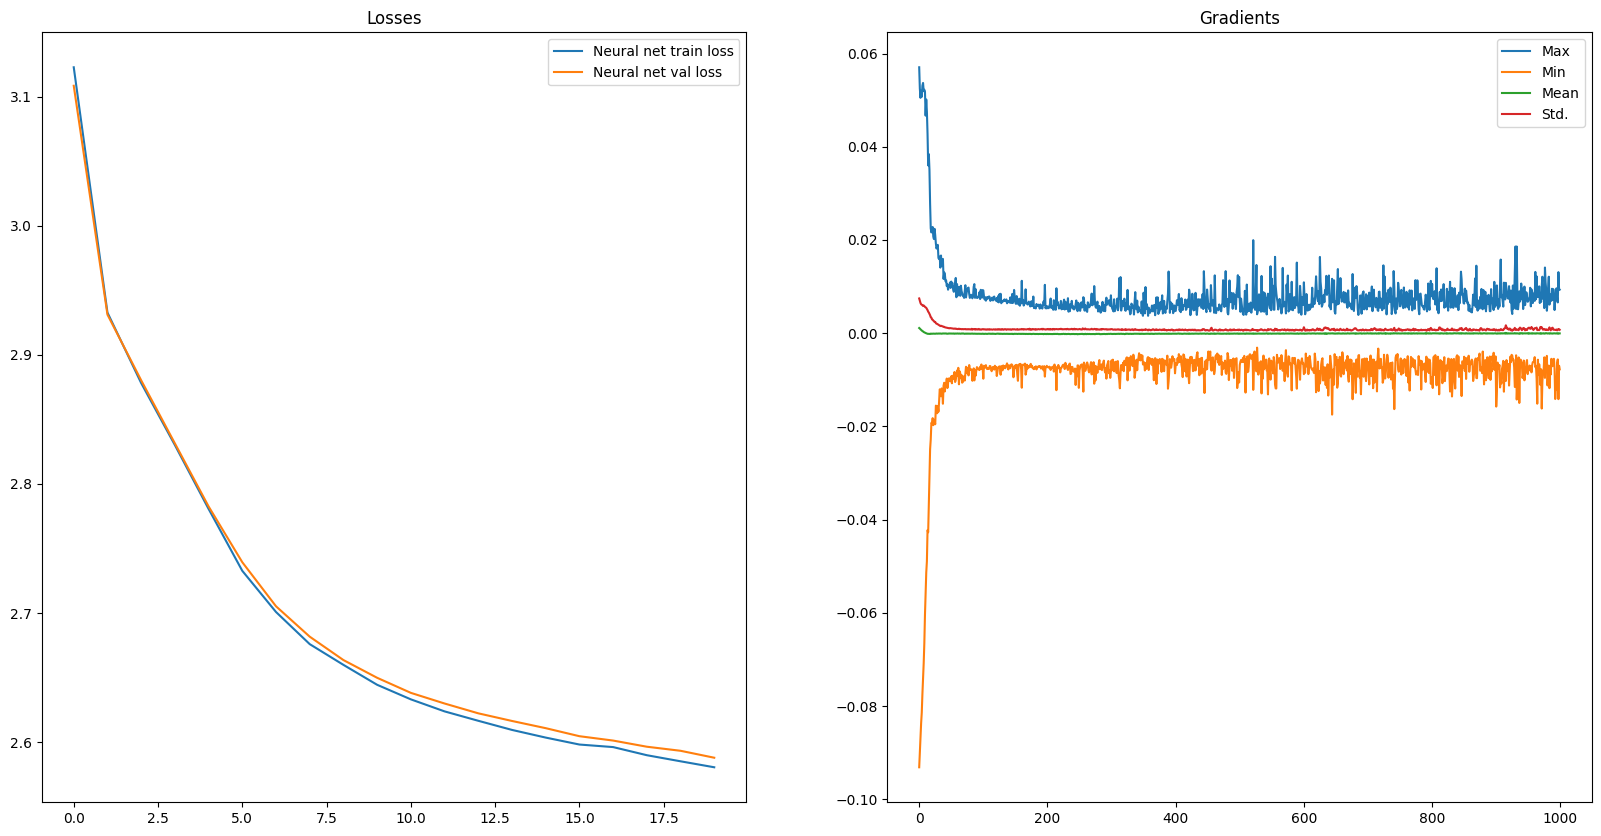

In [46]:
plot_training_loss(trainer)

In [47]:
torch.manual_seed(13)
for i in range(10):
    print(generate(attention_lm, block_size))

oıbiloli
giçipabülsenüduniyilipebamepinrceçlmal
ktanci
zeirüritidamelsmulinpperdklemlik
aunsoreğeaprdolekapom
bazedusvinayk
kagisırenenizükim
beirirorotriekal
agimeygıtdesüvürri
oditlamlrürekelekçüzgcı
